In [4]:
# ---------- IMPORT MODULES ----------
from get_city_graph import get_city_graph
from get_city_data_from_db import get_city_data_from_db
from store_city_to_db import store_city_to_db
from get_or_create_run_config import get_or_create_run_config
from create_iteration import create_iteration
from generate_vehicles import generate_vehicles
from generate_vehicle_routes import generate_vehicle_routes
from generate_congestion import generate_congestion
from plot_congestion_heatmap import plot_congestion_heatmap, plot_congestion_heatmap_interactive
from filter_routes_for_qubo import filter_routes_for_qubo
from get_congestion_weights import get_congestion_weights
from normalize_congestion_weights import normalize_congestion_weights
from congestion_weights import congestion_weights
from qubo_matrix import qubo_matrix

# ---------- CONFIGURATION ----------
from sqlalchemy.orm import sessionmaker
from models import * #City, Node, Edge, RunConfig, Iteration, Vehicle, VehicleRoute, CongestionMap, RoutePoint  # adjust to your actual model imports


CITY_NAME = "Most pri Bratislave, Slovakia"#"Most pri Bratislave, Slovakia"
DIST_THRESH = 10
SPEED_DIFF_THRESH = 2
RUN_CONFIG_ID = 20      
ITERATION_ID = 1
API_KEY = ''

Session = sessionmaker(bind=engine)
session = Session()


city = session.query(City).filter_by(name=CITY_NAME).first()
_, edges = get_city_data_from_db(session, city.id)

In [5]:
# Step : Compute congestion
congestion_df = generate_congestion(
    session, CongestionMap,
    RUN_CONFIG_ID, ITERATION_ID,
    DIST_THRESH, SPEED_DIFF_THRESH
)

In [6]:
edges.head(100)

,id,geometry
0,23335,"LINESTRING (17.2749 48.14099, 17.27446 48.1410..."
1,23336,"LINESTRING (17.2749 48.14099, 17.27503 48.1410..."
2,23337,"LINESTRING (17.2749 48.14099, 17.27527 48.1409..."
3,23338,"LINESTRING (17.27237 48.14115, 17.27282 48.14113)"
4,23339,"LINESTRING (17.27237 48.14115, 17.27232 48.14108)"
...,...,...
95,23430,"LINESTRING (17.27075 48.14088, 17.27122 48.14094)"
96,23431,"LINESTRING (17.27075 48.14088, 17.26935 48.140..."
97,23432,"LINESTRING (17.27122 48.14094, 17.27166 48.13966)"
98,23433,"LINESTRING (17.27122 48.14094, 17.27075 48.14088)"


In [7]:
congestion_df.head(100)


,edge_id,congestion_score
0,23394,0.561381
1,23494,0.559508
2,23512,0.556071
3,23693,1.272593


In [8]:
merged = edges.merge(congestion_df, left_on='id', right_on='edge_id', how='left')
merged = merged.to_crs(epsg=4326)
minx, miny, maxx, maxy = merged.total_bounds
center_lat = (miny + maxy) / 2
center_lon = (minx + maxx) / 2

vmin = merged['congestion_score'].min()
vmax = merged['congestion_score'].max()
print(vmin,vmax)
merged.head(60)

0.5560711944671789 1.2725930917319888


,id,geometry,edge_id,congestion_score
0,23335,"LINESTRING (17.2749 48.14099, 17.27446 48.1410...",NaN,NaN
1,23336,"LINESTRING (17.2749 48.14099, 17.27503 48.1410...",NaN,NaN
2,23337,"LINESTRING (17.2749 48.14099, 17.27527 48.1409...",NaN,NaN
3,23338,"LINESTRING (17.27237 48.14115, 17.27282 48.14113)",NaN,NaN
4,23339,"LINESTRING (17.27237 48.14115, 17.27232 48.14108)",NaN,NaN
5,23340,"LINESTRING (17.27237 48.14115, 17.27222 48.142...",NaN,NaN
6,23341,"LINESTRING (17.27237 48.14115, 17.27222 48.141...",NaN,NaN
7,23342,"LINESTRING (17.26744 48.14082, 17.26752 48.14048)",NaN,NaN
8,23343,"LINESTRING (17.26744 48.14082, 17.26724 48.140...",NaN,NaN
9,23344,"LINESTRING (17.26744 48.14082, 17.26845 48.140...",NaN,NaN


In [3]:
# Step : Plot heatmap
plot_map = plot_congestion_heatmap_interactive(edges, congestion_df,offset_deg=0.000025)
plot_map
plot_map.save("congestion_heatmap.html")

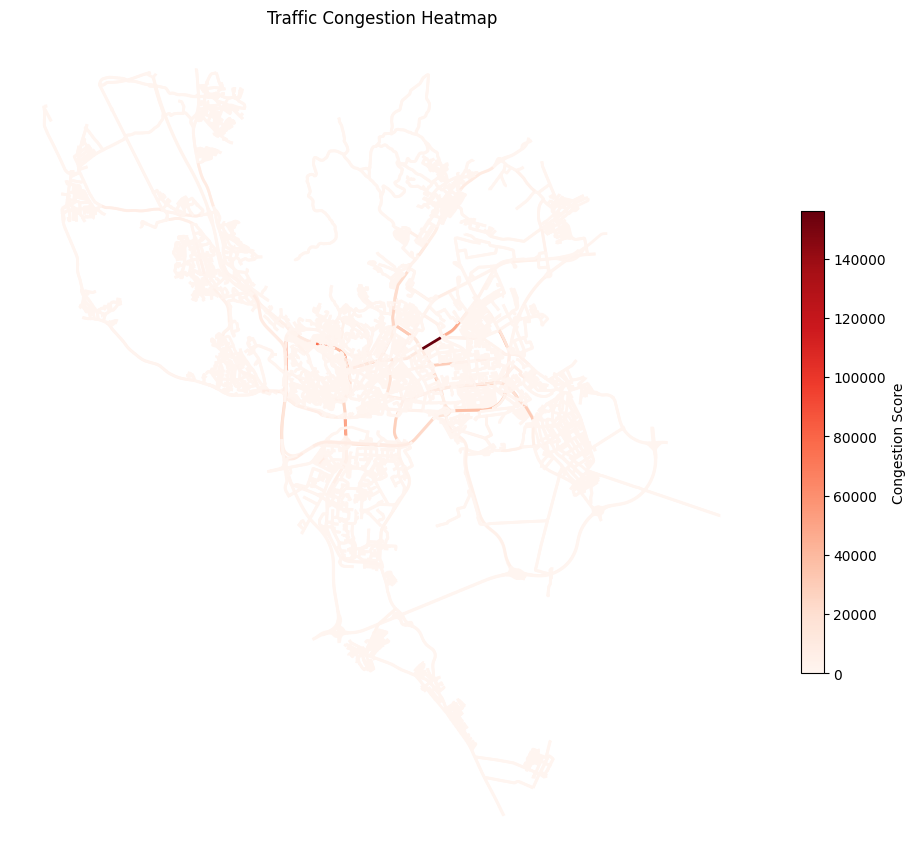

In [4]:
plot_congestion_heatmap(edges, congestion_df)

In [5]:
def get_run_config_params(session, run_config_id, city_name):
    from sqlalchemy import text

    # Step 1: Get city_id
    city_id_result = session.execute(text("""
        SELECT id FROM cities WHERE name = :city_name
    """), {'city_name': city_name}).fetchone()

    if city_id_result is None:
        raise ValueError(f"No city found with name '{city_name}'")

    city_id = city_id_result[0]

    sql = text("""
        SELECT
            id,
            city_id,
            n_cars,
            k_alternatives,
            min_length,
            max_length,
            time_step,
            time_window,
            created_at
        FROM run_configs
        WHERE id = :run_config_id
    """)

    result = session.execute(sql, {'run_config_id': run_config_id, 'city_id': city_id}).fetchone()

    if result is None:
        raise ValueError(f"No run_config found with id={run_config_id}")

    # Return as dictionary
    keys = ['id', 'city_id', 'n_cars', 'k_alternatives', 'min_length',
            'max_length', 'time_step', 'time_window', 'created_at']
    return dict(zip(keys, result))


In [6]:
config = get_run_config_params(session, run_config_id=RUN_CONFIG_ID, city_name = CITY_NAME)
print(config['n_cars'], config['k_alternatives'], config['min_length'])

1000 3 200


In [7]:
def get_routes_df(session, run_config_id, iteration_id):
    from sqlalchemy import text
    import pandas as pd

    query = text("""
        SELECT
            vehicle_id,
            route_id,
            point_id,
            edge_id,
            lat,
            lon,
            time,
            speed,
            cardinal
        FROM trafficOptimization.route_points
        WHERE run_configs_id = :run_config_id
          AND iteration_id = :iteration_id
        ORDER BY vehicle_id, route_id, point_id
    """)

    result = session.execute(query, {
        'run_config_id': run_config_id,
        'iteration_id': iteration_id
    })

    return pd.DataFrame(result.fetchall(), columns=[
        'vehicle_id', 'route_id', 'point_id', 'edge_id',
        'lat', 'lon', 'time', 'speed', 'cardinal'
    ])


In [8]:
def get_congestion_df(session, run_config_id, iteration_id):
    from sqlalchemy import text
    import pandas as pd

    query = text("""
        SELECT
            edge_id,
            congestion_score
        FROM trafficOptimization.congestion_map
        WHERE run_configs_id = :run_config_id
          AND iteration_id = :iteration_id
    """)

    result = session.execute(query, {
        'run_config_id': run_config_id,
        'iteration_id': iteration_id
    })

    return pd.DataFrame(result.fetchall(), columns=['edge_id', 'congestion_score'])


In [9]:



routes_df = get_routes_df(session, RUN_CONFIG_ID, ITERATION_ID)
congestion_df = get_congestion_df(session, RUN_CONFIG_ID, ITERATION_ID)


# Step 8: Filter routes for QUBO
filtered_vehicles = filter_routes_for_qubo(routes_df, congestion_df, threshold_percentile=0.9)
#print(filtered_vehicles)
N_FILTERED = len(filtered_vehicles)
print("Number of elements:", N_FILTERED)

# Step 9: Compute wights from congestion
weights_df = get_congestion_weights(session, RUN_CONFIG_ID, ITERATION_ID, dist_thresh=10.0, speed_diff_thresh=2.0)
print(weights_df)

#weights_normalized = normalize_congestion_weights(weights_df, N_FILTERED, config['k_alternatives'], filtered_vehicles)
#weights_wo_normalization, max_weight = congestion_weights(weights_df, N_FILTERED, config['k_alternatives'], filtered_vehicles)
#print(weights_normalized)



Number of elements: 100
       vehicle_1  vehicle_2  vehicle_1_route  vehicle_2_route  \
0              1        113                2                1   
1              2         59                1                1   
2              2         59                1                2   
3              2        128                1                1   
4              2        128                1                2   
...          ...        ...              ...              ...   
13252        983        995                1                1   
13253        983        995                1                2   
13254        987        999                1                2   
13255        989        990                1                1   
13256        989        992                1                2   

       weighted_congestion_score  
0                       0.988861  
1                       2.585778  
2                       0.934064  
3                       2.646124  
4                   

In [12]:
# Step 10: QUBO
Q, weights, w_c = qubo_matrix(N_FILTERED, config['k_alternatives'], weights_df, filtered_vehicles, lambda_strategy="normalized", fixed_lambda=1.0)
print(filtered_vehicles)
print(weights[1][32][0][0])
print(w_c[1][32][0][0])
print(weights[1][32][1][1])
print(w_c[1][32][1][1])
#for (q1, q2), value in Q.items():
#    print(f"Q[{q1}, {q2}] = {value:.4f}")


|i| = 100, |j| = 100, |k1| = 3, |k2| = 3
min_w = 0.000000, max_w = 54.135347, non-zero weights = 2378
|i| = 100, |j| = 100, |k1| = 3, |k2| = 3
min_w = 0.000000, max_w = 54.135347, non-zero weights = 2378
[26, 44, 50, 53, 62, 70, 91, 114, 131, 134, 151, 152, 159, 174, 181, 183, 186, 189, 198, 205, 220, 248, 252, 260, 263, 266, 288, 295, 314, 334, 341, 347, 353, 359, 376, 380, 382, 385, 410, 420, 427, 431, 438, 450, 462, 464, 470, 477, 479, 482, 509, 511, 519, 523, 525, 540, 560, 561, 565, 567, 570, 572, 593, 624, 640, 648, 651, 652, 683, 711, 727, 732, 735, 774, 776, 795, 798, 821, 824, 835, 841, 872, 873, 876, 902, 906, 913, 917, 918, 932, 938, 939, 944, 948, 950, 951, 954, 973, 980, 982]
0.06062537617019392
3.2819757494645048
0.0093891577634446
0.5082853094554745


In [14]:
import numpy as np
import pandas as pd

def qubo_dict_to_dataframe(Q, size):
    matrix = np.zeros((size, size))
    for (i, j), v in Q.items():
        matrix[i][j] = v
        if i != j:
            matrix[j][i] = v  # ensure symmetry for display
    return pd.DataFrame(matrix), matrix

# Example usage
size = N_FILTERED * config['k_alternatives']
Q_df, matrix = qubo_dict_to_dataframe(Q, size)
print(matrix[4][97])


0.0093891577634446


In [36]:
Q_df.to_csv("qubo_matrix.csv", index=False)
